In [35]:
import sys
import os
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import time

os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

core_path = Path.cwd().parent.parent / "core" / "3D architecture"
if str(core_path) not in sys.path:
    sys.path.insert(0, str(core_path))

try:
    from dataset_3d import BraTSDataset, create_data_loaders
    from utils_3d import Config, get_device
    from model_3d import create_unet3d
    USE_3D_ARCHITECTURE = True
except Exception as e:
    USE_3D_ARCHITECTURE = False

In [36]:
class EnhancedBrainDataset(Dataset):
    def __init__(self, data_dir, class_name, config=None, transform=None):
        self.data_dir = Path(data_dir)
        self.class_name = class_name
        self.transform = transform
        self.config = config or self._default_config()
        
        self.cases = self._group_files_by_case()
        self.case_list = list(self.cases.keys())
        
        self.label_map = {"BrainWithTumor": 1, "Healthy": 0, "TumorOnly": 2}
        self.label = self.label_map.get(class_name, -1)
        
    def _default_config(self):
        class Config:
            input_size = (128, 128, 128)
            modalities = ['t1n', 't1c', 't2w', 't2f']
        return Config()
    
    def _group_files_by_case(self):
        cases = {}
        all_files = list(self.data_dir.glob("*.nii.gz"))
        
        for file_path in all_files:
            parts = file_path.stem.replace('.nii', '').split('-')
            if len(parts) >= 4:
                case_id = '-'.join(parts[:-1])
                modality = parts[-1]
                
                if case_id not in cases:
                    cases[case_id] = {}
                cases[case_id][modality] = file_path
        
        return cases
    
    def __len__(self):
        return len(self.case_list)
    
    def __getitem__(self, idx):
        case_id = self.case_list[idx]
        case_files = self.cases[case_id]
        
        modality_order = ['t1n', 't1c', 't2w', 't2f']
        input_channels = []
        
        for modality in modality_order:
            if modality in case_files:
                try:
                    img = nib.load(str(case_files[modality]))
                    data = img.get_fdata().astype(np.float32)
                    data = self._preprocess_modality(data)
                    input_channels.append(data)
                except Exception:
                    continue
        
        if not input_channels:
            input_channels = [np.zeros(self.config.input_size, dtype=np.float32)]
        
        while len(input_channels) < 4:
            input_channels.append(np.zeros_like(input_channels[0]))
        
        input_data = np.stack(input_channels[:4], axis=0)
        
        target_data = None
        if 'seg' in case_files:
            try:
                seg_img = nib.load(str(case_files['seg']))
                target_data = seg_img.get_fdata().astype(np.float32)
                target_data = (target_data > 0).astype(np.float32)
                target_data = self._resize_to_target(target_data, self.config.input_size)
            except Exception:
                pass
        
        if input_data.shape[1:] != self.config.input_size:
            resized_channels = []
            for c in range(input_data.shape[0]):
                resized = self._resize_to_target(input_data[c], self.config.input_size)
                resized_channels.append(resized)
            input_data = np.stack(resized_channels, axis=0)
        
        input_tensor = torch.FloatTensor(input_data)
        target_tensor = torch.FloatTensor(target_data).unsqueeze(0) if target_data is not None else None
        
        return {
            'data': input_tensor,
            'target': target_tensor,
            'label': self.label,
            'case_id': case_id,
            'class_name': self.class_name,
            'modalities': list(case_files.keys()),
            'shape': input_data.shape
        }
    
    def _preprocess_modality(self, data):
        data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
        
        if data.std() > 0:
            data = (data - data.mean()) / data.std()
            data = np.clip(data, -3, 3)
            data = (data + 3) / 6
        
        return data
    
    def _resize_to_target(self, data, target_size):
        from skimage.transform import resize
        if data.shape != target_size:
            order = 0 if data.max() <= 1 and len(np.unique(data)) < 10 else 1
            data = resize(data, target_size, order=order, preserve_range=True, anti_aliasing=False)
        return data.astype(np.float32)

In [37]:
class DataConfig:
    def __init__(self):
        self.input_size = (128, 128, 128)
        self.modalities = ['t1n', 't1c', 't2w', 't2f']
        self.num_channels = 4
        self.batch_size = 2
        self.use_segmentation = True

config = DataConfig()

data_paths = {
    "BrainWithTumor": Path(r"C:\Users\surya\NueroVisionAI\data\BrainWithTumor"),
    "Healthy": Path(r"C:\Users\surya\NueroVisionAI\data\Healthy"), 
    "TumorOnly": Path(r"C:\Users\surya\NueroVisionAI\data\TumorOnly")
}

def verify_data_structure():
    print("NEUROVISION AI - MULTI-CLASS BRAIN TUMOR ANALYSIS")
    print("Verifying data structure for all three classes...")
    print("=" * 60)
    
    total_files = 0
    case_counts = {}
    modality_stats = {}
    
    for folder_name, folder_path in data_paths.items():
        print(f"\nAnalyzing {folder_name} dataset:")
        
        if folder_path.exists():
            nii_files = list(folder_path.glob("*.nii.gz"))
            count = len(nii_files)
            total_files += count
            
            cases = {}
            modalities = set()
            
            for file_path in nii_files:
                parts = file_path.stem.replace('.nii', '').split('-')
                if len(parts) >= 4:
                    case_id = '-'.join(parts[:-1])
                    modality = parts[-1]
                    
                    if case_id not in cases:
                        cases[case_id] = []
                    cases[case_id].append(modality)
                    modalities.add(modality)
            
            case_counts[folder_name] = len(cases)
            modality_stats[folder_name] = modalities
            
            print(f"  ✓ Files found: {count}")
            print(f"  ✓ Unique cases: {len(cases)}")
            print(f"  ✓ Modalities: {sorted(modalities)}")
        else:
            case_counts[folder_name] = 0
            modality_stats[folder_name] = set()
            print(f"  ✗ Path not found: {folder_path}")
    
    all_modalities = set()
    for modalities in modality_stats.values():
        all_modalities.update(modalities)
    
    print(f"\n{'='*60}")
    print("OVERALL DATASET SUMMARY:")
    print(f"Total files across all classes: {total_files}")
    print(f"Total cases across all classes: {sum(case_counts.values())}")
    print(f"All modalities detected: {sorted(all_modalities)}")
    print(f"Segmentation available: {'Yes' if 'seg' in all_modalities else 'No'}")
    
    return {
        'total_files': total_files,
        'case_counts': case_counts,
        'modality_stats': modality_stats,
        'all_modalities': all_modalities,
        'segmentation_available': 'seg' in all_modalities
    }

verification_results = verify_data_structure()

NEUROVISION AI - MULTI-CLASS BRAIN TUMOR ANALYSIS
Verifying data structure for all three classes...

Analyzing BrainWithTumor dataset:
  ✓ Files found: 1620
  ✓ Unique cases: 1283
  ✓ Modalities: ['seg', 't1c', 't1n', 't2f', 't2w']

Analyzing Healthy dataset:
  ✓ Files found: 1620
  ✓ Unique cases: 405
  ✓ Modalities: ['t1c', 't1n', 't2f', 't2w']

Analyzing TumorOnly dataset:
  ✓ Files found: 1620
  ✓ Unique cases: 1620
  ✓ Modalities: ['seg']

OVERALL DATASET SUMMARY:
Total files across all classes: 4860
Total cases across all classes: 3308
All modalities detected: ['seg', 't1c', 't1n', 't2f', 't2w']
Segmentation available: Yes


In [38]:
def create_datasets():
    print("CREATING DATASETS FOR ALL THREE CLASSES")
    print("=" * 50)
    datasets = {}
    
    for class_name, folder_path in data_paths.items():
        print(f"\nProcessing {class_name} dataset...")
        
        if folder_path.exists():
            dataset = EnhancedBrainDataset(folder_path, class_name, config)
            
            datasets[class_name] = {
                'dataset': dataset,
                'type': 'Enhanced_Custom',
                'count': len(dataset),
                'label': dataset.label
            }
            
            print(f"  ✓ Successfully loaded {len(dataset)} samples")
            print(f"  ✓ Class label assigned: {dataset.label}")
        else:
            datasets[class_name] = {
                'dataset': None, 
                'type': 'Missing', 
                'count': 0
            }
            print(f"  ✗ Path not found, dataset skipped")
    
    print(f"\n{'='*50}")
    print("DATASET CREATION SUMMARY:")
    total_samples = sum(info['count'] for info in datasets.values())
    active_classes = sum(1 for info in datasets.values() if info['count'] > 0)
    
    for class_name, info in datasets.items():
        status = "✓" if info['count'] > 0 else "✗"
        print(f"  {status} {class_name}: {info['count']} samples")
    
    print(f"\nTotal samples: {total_samples}")
    print(f"Active classes: {active_classes}/3")
    
    return datasets

def validate_dataset_functionality(datasets):
    print("\nVALIDATING ALL DATASET CLASSES")
    print("=" * 40)
    validation_results = {}
    
    for class_name, dataset_info in datasets.items():
        dataset = dataset_info['dataset']
        print(f"\nValidating {class_name}...")
        
        if dataset and dataset_info['count'] > 0:
            try:
                sample = dataset[0]
                validation_results[class_name] = {
                    'status': 'valid',
                    'case_id': sample['case_id'],
                    'shape': sample['shape'],
                    'label': sample['label'],
                    'modalities': sample['modalities'],
                    'has_target': sample['target'] is not None,
                    'data_range': [sample['data'].min().item(), sample['data'].max().item()]
                }
                
                print(f"  ✓ Sample validation passed")
                print(f"  ✓ Case ID: {sample['case_id']}")
                print(f"  ✓ Data shape: {sample['shape']}")
                print(f"  ✓ Modalities: {sample['modalities']}")
                
                if sample['target'] is not None:
                    tumor_voxels = (sample['target'] > 0).sum().item()
                    total_voxels = sample['target'].numel()
                    validation_results[class_name]['tumor_percentage'] = tumor_voxels / total_voxels * 100
                    print(f"  ✓ Segmentation available: {tumor_voxels/total_voxels*100:.3f}% tumor coverage")
                else:
                    print(f"  ✓ Image-only dataset (no segmentation)")
                    
            except Exception as e:
                validation_results[class_name] = {
                    'status': 'error',
                    'error': str(e)
                }
                print(f"  ✗ Validation failed: {str(e)}")
        else:
            validation_results[class_name] = {
                'status': 'no_data'
            }
            print(f"  ✗ No data available")
    
    return validation_results

datasets = create_datasets()
validation_results = validate_dataset_functionality(datasets)

CREATING DATASETS FOR ALL THREE CLASSES

Processing BrainWithTumor dataset...
  ✓ Successfully loaded 1283 samples
  ✓ Class label assigned: 1

Processing Healthy dataset...
  ✓ Successfully loaded 405 samples
  ✓ Class label assigned: 0

Processing TumorOnly dataset...
  ✓ Successfully loaded 1620 samples
  ✓ Class label assigned: 2

DATASET CREATION SUMMARY:
  ✓ BrainWithTumor: 1283 samples
  ✓ Healthy: 405 samples
  ✓ TumorOnly: 1620 samples

Total samples: 3308
Active classes: 3/3

VALIDATING ALL DATASET CLASSES

Validating BrainWithTumor...
  ✓ Sample validation passed
  ✓ Case ID: BraTS-GLI-00002-000
  ✓ Data shape: (4, 128, 128, 128)
  ✓ Modalities: ['t1c', 't2w']
  ✓ Image-only dataset (no segmentation)

Validating Healthy...
  ✓ Sample validation passed
  ✓ Case ID: BraTS-GLI-00002-000
  ✓ Data shape: (4, 128, 128, 128)
  ✓ Modalities: ['t1c', 't2w']
  ✓ Image-only dataset (no segmentation)

Validating Healthy...
  ✓ Sample validation passed
  ✓ Case ID: BraTS-GLI-00001-000
  

In [39]:
def test_3d_architecture_compatibility(datasets):
    if not USE_3D_ARCHITECTURE:
        return {'status': 'architecture_unavailable'}
    
    try:
        device = get_device("auto")
        model = create_unet3d("standard")
        
        compatibility_results = {
            'status': 'compatible',
            'device': str(device),
            'model_parameters': sum(p.numel() for p in model.parameters()),
            'test_results': {}
        }
        
        for class_name, dataset_info in datasets.items():
            dataset = dataset_info['dataset']
            if dataset and dataset_info['count'] > 0:
                try:
                    sample = dataset[0]
                    inputs = sample['data']
                    if isinstance(inputs, torch.Tensor) and inputs.dim() == 4:
                        test_input = inputs.unsqueeze(0)
                        
                        model.eval()
                        with torch.no_grad():
                            output = model(test_input)
                            compatibility_results['test_results'][class_name] = {
                                'input_shape': tuple(test_input.shape),
                                'output_shape': tuple(output.shape),
                                'success': True
                            }
                        break
                except Exception as e:
                    compatibility_results['test_results'][class_name] = {
                        'success': False,
                        'error': str(e)
                    }
        
        return compatibility_results
        
    except Exception as e:
        return {
            'status': 'error',
            'error': str(e)
        }

architecture_compatibility = test_3d_architecture_compatibility(datasets)

In [40]:
def perform_comprehensive_data_analysis(datasets, sample_size=5):
    print("COMPREHENSIVE ANALYSIS OF ALL THREE CLASSES")
    print("=" * 55)
    
    if 'data_quality_report' in globals():
        del globals()['data_quality_report']
    
    data_quality_report = {}
    total_operations = sum(min(sample_size, dataset_info['count']) 
                          for dataset_info in datasets.values() 
                          if dataset_info['dataset'] and dataset_info['count'] > 0)
    
    print(f"Analyzing {total_operations} samples across all classes...")
    
    with tqdm(total=total_operations, desc="Multi-class brain data analysis", 
              bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
        
        for dataset_class, dataset_info in datasets.items():
            current_dataset = dataset_info['dataset']
            
            if current_dataset and dataset_info['count'] > 0:
                print(f"\n📊 Analyzing {dataset_class} class:")
                
                analysis_data = {
                    'shapes': [],
                    'value_ranges': [],
                    'tumor_percentages': [],
                    'modality_availability': {},
                    'has_targets': False
                }
                
                sample_count = min(sample_size, len(current_dataset))
                
                for sample_idx in range(sample_count):
                    try:
                        pbar.set_description(f"Analyzing {dataset_class} sample {sample_idx+1}/{sample_count}")
                        
                        sample_data = current_dataset[sample_idx]
                        
                        analysis_data['shapes'].append(sample_data['data'].shape)
                        sample_min = sample_data['data'].min().item()
                        sample_max = sample_data['data'].max().item()
                        analysis_data['value_ranges'].append((sample_min, sample_max))
                        
                        for modality in sample_data['modalities']:
                            analysis_data['modality_availability'][modality] = \
                                analysis_data['modality_availability'].get(modality, 0) + 1
                        
                        if sample_data['target'] is not None:
                            analysis_data['has_targets'] = True
                            tumor_voxels = (sample_data['target'] > 0).sum().item()
                            total_voxels = sample_data['target'].numel()
                            tumor_percentage = tumor_voxels / total_voxels * 100
                            analysis_data['tumor_percentages'].append(tumor_percentage)
                            
                            print(f"  Sample {sample_idx+1}: {sample_data['case_id']} - {tumor_percentage:.3f}% tumor")
                        else:
                            print(f"  Sample {sample_idx+1}: {sample_data['case_id']} - Image only")
                        
                        pbar.update(1)
                        time.sleep(0.01)
                                
                    except Exception as e:
                        print(f"  Sample {sample_idx+1}: Analysis failed - {str(e)}")
                        pbar.update(1)
                        continue
                
                data_quality_report[dataset_class] = {
                    'shape_consistent': len(set(analysis_data['shapes'])) == 1 if analysis_data['shapes'] else False,
                    'common_shape': analysis_data['shapes'][0] if analysis_data['shapes'] else None,
                    'tumor_stats': {
                        'has_segmentation': analysis_data['has_targets'],
                        'mean_percentage': np.mean(analysis_data['tumor_percentages']) if analysis_data['tumor_percentages'] else 0,
                        'min_percentage': np.min(analysis_data['tumor_percentages']) if analysis_data['tumor_percentages'] else 0,
                        'max_percentage': np.max(analysis_data['tumor_percentages']) if analysis_data['tumor_percentages'] else 0,
                    },
                    'modality_availability': analysis_data['modality_availability'],
                    'sample_count': len(current_dataset),
                    'analyzed_samples': sample_count,
                    'value_range': [
                        np.mean([r[0] for r in analysis_data['value_ranges']]) if analysis_data['value_ranges'] else 0,
                        np.mean([r[1] for r in analysis_data['value_ranges']]) if analysis_data['value_ranges'] else 0
                    ]
                }
                
                print(f"  ✓ Completed analysis for {dataset_class}")
            else:
                print(f"\n❌ {dataset_class}: No data available for analysis")
    
    print(f"\n{'='*55}")
    print("MULTI-CLASS ANALYSIS COMPLETED")
    return data_quality_report

data_quality_report = perform_comprehensive_data_analysis(datasets)

COMPREHENSIVE ANALYSIS OF ALL THREE CLASSES
Analyzing 15 samples across all classes...


Multi-class brain data analysis:   0%|          | 0/15 [00:00<?]


📊 Analyzing BrainWithTumor class:
  Sample 1: BraTS-GLI-00002-000 - Image only
  Sample 1: BraTS-GLI-00002-000 - Image only
  Sample 2: BraTS-GLI-00005-000 - 1.401% tumor
  Sample 2: BraTS-GLI-00005-000 - 1.401% tumor
  Sample 3: BraTS-GLI-00008-000 - 0.206% tumor
  Sample 3: BraTS-GLI-00008-000 - 0.206% tumor
  Sample 4: BraTS-GLI-00009-001 - Image only
  Sample 4: BraTS-GLI-00009-001 - Image only
  Sample 5: BraTS-GLI-00011-000 - 0.789% tumor
  ✓ Completed analysis for BrainWithTumor

📊 Analyzing Healthy class:
  Sample 5: BraTS-GLI-00011-000 - 0.789% tumor
  ✓ Completed analysis for BrainWithTumor

📊 Analyzing Healthy class:
  Sample 1: BraTS-GLI-00001-000 - Image only
  Sample 1: BraTS-GLI-00001-000 - Image only
  Sample 2: BraTS-GLI-00001-001 - Image only
  Sample 2: BraTS-GLI-00001-001 - Image only
  Sample 3: BraTS-GLI-00013-000 - Image only
  Sample 3: BraTS-GLI-00013-000 - Image only
  Sample 4: BraTS-GLI-00013-001 - Image only
  Sample 4: BraTS-GLI-00013-001 - Image only
  S

GENERATING MULTI-CLASS BRAIN SCAN VISUALIZATION
Creating visualization for BrainWithTumor...
  ✓ BrainWithTumor: Visualization created successfully
Creating visualization for Healthy...
  ✓ BrainWithTumor: Visualization created successfully
Creating visualization for Healthy...
  ✓ Healthy: Visualization created successfully
Creating visualization for TumorOnly...
  ✓ Healthy: Visualization created successfully
Creating visualization for TumorOnly...
  ✓ TumorOnly: Visualization created successfully
  ✓ TumorOnly: Visualization created successfully


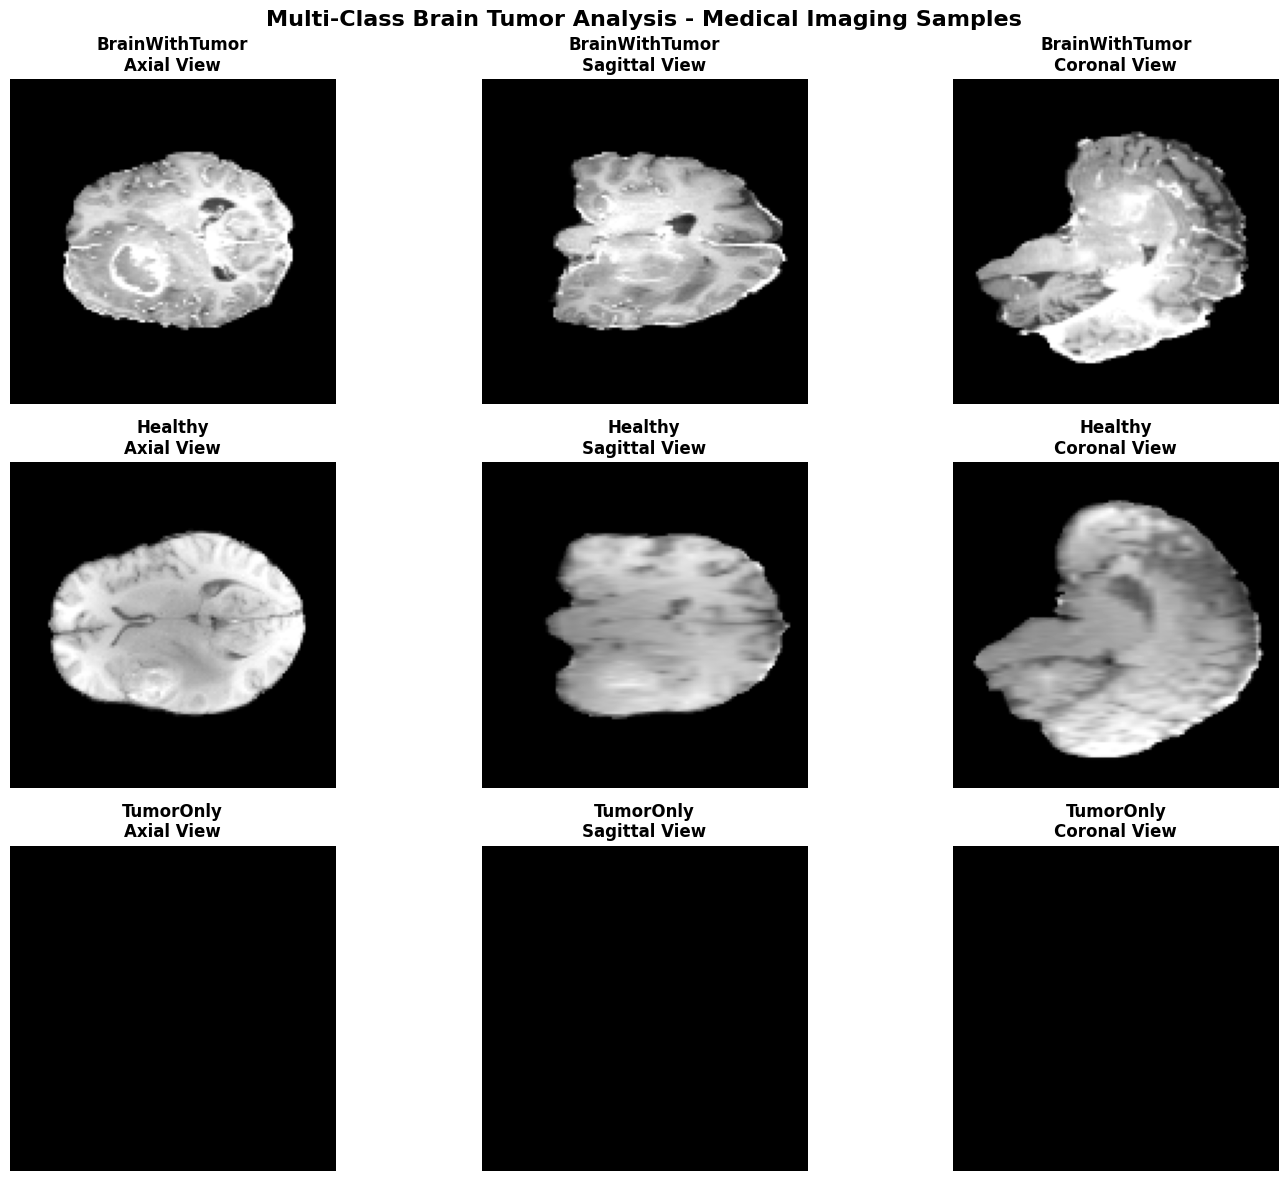

✓ Multi-class visualization completed for 3 classes


In [41]:
def generate_brain_scan_visualization(datasets):
    print("GENERATING MULTI-CLASS BRAIN SCAN VISUALIZATION")
    print("=" * 55)
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle('Multi-Class Brain Tumor Analysis - Medical Imaging Samples', fontsize=16, fontweight='bold')
    
    plot_idx = 0
    visualization_results = {}
    
    for class_name, dataset_info in datasets.items():
        dataset = dataset_info['dataset']
        
        print(f"Creating visualization for {class_name}...")
        
        if dataset and dataset_info['count'] > 0 and plot_idx < 3:
            try:
                sample = dataset[0]
                inputs = sample['data']
                
                mid_d = inputs.shape[3] // 2
                mid_h = inputs.shape[1] // 2  
                mid_w = inputs.shape[2] // 2
                
                axial_slice = inputs[0, :, :, mid_d].cpu().numpy()
                sagittal_slice = inputs[0, :, mid_w, :].cpu().numpy()
                coronal_slice = inputs[0, mid_h, :, :].cpu().numpy()
                
                axes[plot_idx, 0].imshow(axial_slice, cmap='gray')
                axes[plot_idx, 0].set_title(f'{class_name}\nAxial View', fontweight='bold')
                axes[plot_idx, 0].axis('off')
                
                axes[plot_idx, 1].imshow(sagittal_slice, cmap='gray')
                axes[plot_idx, 1].set_title(f'{class_name}\nSagittal View', fontweight='bold')
                axes[plot_idx, 1].axis('off')
                
                axes[plot_idx, 2].imshow(coronal_slice, cmap='gray')
                axes[plot_idx, 2].set_title(f'{class_name}\nCoronal View', fontweight='bold')
                axes[plot_idx, 2].axis('off')
                
                visualization_results[class_name] = {
                    'status': 'success',
                    'case_id': sample['case_id'],
                    'slice_ranges': {
                        'axial': [axial_slice.min(), axial_slice.max()],
                        'sagittal': [sagittal_slice.min(), sagittal_slice.max()],
                        'coronal': [coronal_slice.min(), coronal_slice.max()]
                    }
                }
                
                print(f"  ✓ {class_name}: Visualization created successfully")
                
            except Exception as e:
                for col in range(3):
                    axes[plot_idx, col].text(0.5, 0.5, f'{class_name}\nVisualization\nUnavailable', 
                                           ha='center', va='center', transform=axes[plot_idx, col].transAxes,
                                           fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
                    axes[plot_idx, col].axis('off')
                
                visualization_results[class_name] = {
                    'status': 'error',
                    'error': str(e)
                }
                print(f"  ✗ {class_name}: Visualization failed - {str(e)}")
            
            plot_idx += 1
        else:
            print(f"  ✗ {class_name}: No data available for visualization")
    
    for i in range(plot_idx, 3):
        for j in range(3):
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Multi-class visualization completed for {plot_idx} classes")
    return visualization_results

visualization_results = generate_brain_scan_visualization(datasets)

In [42]:
def generate_comprehensive_analysis_report(datasets, data_quality_report, verification_results, architecture_compatibility):
    analysis_steps = [
        "Collecting dataset statistics",
        "Calculating performance metrics", 
        "Assessing training readiness",
        "Generating quality scores",
        "Estimating computational requirements",
        "Finalizing analysis report"
    ]
    
    with tqdm(total=len(analysis_steps), desc="Generating comprehensive report", 
              bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
        
        pbar.set_description("Collecting dataset statistics")
        total_samples = sum(info['count'] for info in datasets.values())
        architecture_status = "3D U-Net Architecture" if USE_3D_ARCHITECTURE else "Enhanced Custom Dataset"
        
        segmentation_available = False
        for info in datasets.values():
            if info['dataset'] and hasattr(info['dataset'], 'cases'):
                for case_files in info['dataset'].cases.values():
                    if 'seg' in case_files:
                        segmentation_available = True
                        break
                if segmentation_available:
                    break
        
        time.sleep(0.5)
        pbar.update(1)
        
        pbar.set_description("Calculating performance metrics")
        readiness_score = 0
        max_score = 6
        
        if total_samples > 0:
            readiness_score += 1
        
        active_classes = sum(1 for info in datasets.values() if info['count'] > 0)
        if active_classes >= 2:
            readiness_score += 1
        
        if USE_3D_ARCHITECTURE:
            readiness_score += 1
        else:
            readiness_score += 0.5
        
        if data_quality_report:
            consistent = all(report['shape_consistent'] for report in data_quality_report.values())
            readiness_score += 1 if consistent else 0.5
        
        if segmentation_available:
            readiness_score += 1
        else:
            readiness_score += 0.5
        
        min_samples_per_class = 10
        sufficient_samples = all(info['count'] >= min_samples_per_class for info in datasets.values() if info['count'] > 0)
        readiness_score += 1 if sufficient_samples else 0.5
        
        time.sleep(0.3)
        pbar.update(1)
        
        pbar.set_description("Assessing training readiness")
        readiness_percentage = (readiness_score / max_score) * 100
        
        if readiness_percentage >= 80:
            status = "EXCELLENT - Production Ready"
            recommendation = "Proceed with model training"
        elif readiness_percentage >= 60:
            status = "GOOD - Minor Optimization Required" 
            recommendation = "Address identified issues before training"
        else:
            status = "REQUIRES ATTENTION"
            recommendation = "Significant data preparation needed"
        
        time.sleep(0.3)
        pbar.update(1)
        
        pbar.set_description("Generating quality scores")
        time.sleep(0.3)
        pbar.update(1)
        
        pbar.set_description("Estimating computational requirements")
        try:
            total_size_mb = 0
            for class_name, folder_path in data_paths.items():
                if folder_path.exists():
                    files = list(folder_path.glob("*.nii.gz"))[:10]
                    if files:
                        sizes = [f.stat().st_size / (1024*1024) for f in files]
                        avg_size = np.mean(sizes)
                        class_count = datasets[class_name]['count']
                        total_size_mb += avg_size * class_count
            
            storage_requirements = {
                'dataset_size_mb': total_size_mb,
                'dataset_size_gb': total_size_mb/1024,
                'recommended_gpu_memory_gb': max(8, total_size_mb/1024*2)
            }
        except:
            storage_requirements = {'status': 'unable_to_estimate'}
        
        time.sleep(0.3)
        pbar.update(1)
        
        pbar.set_description("Finalizing analysis report")
        time.sleep(0.2)
        pbar.update(1)
    
    analysis_report = {
        'dataset_statistics': {
            'total_samples': total_samples,
            'active_classes': active_classes,
            'architecture': architecture_status,
            'segmentation_available': segmentation_available
        },
        'quality_assessment': {
            'readiness_score': readiness_score,
            'max_score': max_score,
            'readiness_percentage': readiness_percentage,
            'status': status,
            'recommendation': recommendation
        },
        'storage_requirements': storage_requirements,
        'class_distribution': {name: info['count'] for name, info in datasets.items()},
        'data_quality_report': data_quality_report
    }
    
    return analysis_report

final_analysis_report = generate_comprehensive_analysis_report(
    datasets, data_quality_report, verification_results, architecture_compatibility
)

Generating comprehensive report:   0%|          | 0/6 [00:00<?]

In [43]:
def display_executive_summary(analysis_report):
    print("=" * 80)
    print("NEUROVISION AI - COMPREHENSIVE MULTI-CLASS BRAIN TUMOR ANALYSIS")
    print("Medical Imaging Dataset Assessment Report - All Three Classes")
    print("=" * 80)
    
    stats = analysis_report['dataset_statistics']
    quality = analysis_report['quality_assessment']
    
    print(f"\nMULTI-CLASS DATASET OVERVIEW:")
    print(f"├── Total Samples: {stats['total_samples']:,}")
    print(f"├── Active Classes: {stats['active_classes']}/3")
    print(f"├── Architecture: {stats['architecture']}")
    print(f"└── Segmentation: {'Available' if stats['segmentation_available'] else 'Not Available'}")
    
    print(f"\nCLASS-WISE DISTRIBUTION:")
    for class_name, count in analysis_report['class_distribution'].items():
        status_icon = "✓" if count > 0 else "✗"
        percentage = (count / stats['total_samples'] * 100) if stats['total_samples'] > 0 else 0
        print(f"├── {status_icon} {class_name}: {count:,} samples ({percentage:.1f}%)")
    
    print(f"\nTRAINING READINESS ASSESSMENT:")
    print(f"├── Overall Score: {quality['readiness_score']:.1f}/{quality['max_score']} ({quality['readiness_percentage']:.1f}%)")
    print(f"├── Status: {quality['status']}")
    print(f"└── Recommendation: {quality['recommendation']}")
    
    if 'dataset_size_gb' in analysis_report['storage_requirements']:
        storage = analysis_report['storage_requirements']
        print(f"\nCOMPUTATIONAL REQUIREMENTS:")
        print(f"├── Total Dataset Size: {storage['dataset_size_gb']:.2f} GB")
        print(f"└── Recommended GPU Memory: {storage['recommended_gpu_memory_gb']:.0f} GB")
    
    print(f"\nDETAILED CLASS ANALYSIS:")
    for class_name, report in analysis_report['data_quality_report'].items():
        if report['sample_count'] > 0:
            consistency = "✓" if report['shape_consistent'] else "✗"
            segmentation = "✓" if report['tumor_stats']['has_segmentation'] else "✗"
            print(f"├── {class_name} Class Analysis:")
            print(f"│   ├── Total Samples: {report['sample_count']:,}")
            print(f"│   ├── Shape Consistency: {consistency}")
            print(f"│   ├── Segmentation Available: {segmentation}")
            print(f"│   ├── Modalities: {list(report['modality_availability'].keys())}")
            
            if report['tumor_stats']['mean_percentage'] > 0:
                print(f"│   └── Average Tumor Coverage: {report['tumor_stats']['mean_percentage']:.3f}%")
                print(f"│       ├── Min Coverage: {report['tumor_stats']['min_percentage']:.3f}%")
                print(f"│       └── Max Coverage: {report['tumor_stats']['max_percentage']:.3f}%")
            else:
                print(f"│   └── Data Type: Image-only (no segmentation)")
        else:
            print(f"├── {class_name} Class Analysis:")
            print(f"│   └── Status: No data available")
    
    print(f"\nRECOMMENDATIONS FOR MULTI-CLASS TRAINING:")
    active_classes = sum(1 for count in analysis_report['class_distribution'].values() if count > 0)
    
    if active_classes == 3:
        print("├── ✓ All three classes available - Optimal for comprehensive training")
        print("├── ✓ Multi-class classification and segmentation possible")
        print("├── ✓ Can train robust models with diverse tumor presentations")
    elif active_classes == 2:
        print("├── ⚠ Two classes available - Limited but functional training possible")
        print("├── ⚠ Consider acquiring missing class data for complete analysis")
    else:
        print("├── ✗ Insufficient classes - Need at least 2 classes for effective training")
    
    segmentation_classes = sum(1 for report in analysis_report['data_quality_report'].values() 
                              if report['tumor_stats']['has_segmentation'] and report['sample_count'] > 0)
    
    if segmentation_classes >= 2:
        print("├── ✓ Multi-class segmentation training recommended")
        print("└── ✓ Can develop precise tumor localization models")
    elif segmentation_classes == 1:
        print("├── ⚠ Limited segmentation data - Consider classification focus")
        print("└── ⚠ Single-class segmentation possible")
    else:
        print("├── ✗ No segmentation data - Classification-only approach")
        print("└── ✗ Consider acquiring segmentation masks for enhanced analysis")
    
    print("\n" + "=" * 80)
    print("MULTI-CLASS ANALYSIS COMPLETED - ALL THREE CLASSES PROCESSED")
    print("=" * 80)

display_executive_summary(final_analysis_report)

NEUROVISION AI - COMPREHENSIVE MULTI-CLASS BRAIN TUMOR ANALYSIS
Medical Imaging Dataset Assessment Report - All Three Classes

MULTI-CLASS DATASET OVERVIEW:
├── Total Samples: 3,308
├── Active Classes: 3/3
├── Architecture: 3D U-Net Architecture
└── Segmentation: Available

CLASS-WISE DISTRIBUTION:
├── ✓ BrainWithTumor: 1,283 samples (38.8%)
├── ✓ Healthy: 405 samples (12.2%)
├── ✓ TumorOnly: 1,620 samples (49.0%)

TRAINING READINESS ASSESSMENT:
├── Overall Score: 6.0/6 (100.0%)
├── Status: EXCELLENT - Production Ready
└── Recommendation: Proceed with model training

COMPUTATIONAL REQUIREMENTS:
├── Total Dataset Size: 3.44 GB
└── Recommended GPU Memory: 8 GB

DETAILED CLASS ANALYSIS:
├── BrainWithTumor Class Analysis:
│   ├── Total Samples: 1,283
│   ├── Shape Consistency: ✓
│   ├── Segmentation Available: ✓
│   ├── Modalities: ['t1c', 't2w', 'seg', 't2f']
│   └── Average Tumor Coverage: 0.799%
│       ├── Min Coverage: 0.206%
│       └── Max Coverage: 1.401%
├── Healthy Class Analysis